In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier
import optuna
import mlflow
import mlflow.catboost
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
from typing import Tuple, Dict, Any


# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class MLflowTrainingManager:
    def __init__(
        self,
        experiment_name: str,
        tracking_uri: str = "http://localhost:5000",
        db_path: str = "mlflow.db"
    ):
        """
        Initialize MLflow training manager
       
        Parameters:
        -----------
        experiment_name : str
            Name of the MLflow experiment
        tracking_uri : str
            MLflow tracking server URI
        db_path : str
            Path to SQLite database for MLflow
        """
        self.experiment_name = experiment_name
        self.tracking_uri = tracking_uri
        self.db_path = db_path
        self.setup_mlflow()


    def setup_mlflow(self):
        """Set up MLflow tracking server and experiment"""
        try:
            # Set up SQLite backend
            os.environ['MLFLOW_TRACKING_URI'] = f'sqlite:///{self.db_path}'
           
            # Set tracking URI
            mlflow.set_tracking_uri(self.tracking_uri)
           
            # Create or get experiment
            try:
                experiment = mlflow.get_experiment_by_name(self.experiment_name)
                if experiment is None:
                    mlflow.create_experiment(self.experiment_name)
            except Exception as e:
                logger.error(f"Error creating experiment: {e}")
                raise
           
            mlflow.set_experiment(self.experiment_name)
            logger.info(f"MLflow setup complete. Experiment: {self.experiment_name}")
            logger.info(f"Tracking URI: {mlflow.get_tracking_uri()}")
           
        except Exception as e:
            logger.error(f"Error setting up MLflow: {e}")
            raise


    def train_model(
        self,
        df: pd.DataFrame,
        target_col: str = 'Outcome',
        n_trials: int = 100
    ) -> Tuple[CatBoostClassifier, Dict[str, float]]:
        """
        Train model with MLflow tracking
       
        Parameters:
        -----------
        df : pd.DataFrame
            Input dataset
        target_col : str
            Target column name
        n_trials : int
            Number of optimization trials
           
        Returns:
        --------
        Tuple containing:
            - Trained CatBoost model
            - Dictionary of evaluation metrics
        """
        X_train, X_test, y_train, y_test = self._prepare_data(df, target_col)
       
        # Optimize hyperparameters
        study = optuna.create_study(direction='maximize')
        study.optimize(
            lambda trial: self._objective(trial, X_train, X_test, y_train, y_test),
            n_trials=n_trials
        )
       
        # Train final model with best parameters
        with mlflow.start_run() as run:
            logger.info(f"Started MLflow run: {run.info.run_id}")
           
            best_params = study.best_params
            mlflow.log_params(best_params)
           
            model = CatBoostClassifier(**best_params, random_state=42)
            model.fit(
                X_train, y_train,
                eval_set=(X_test, y_test),
                early_stopping_rounds=50,
                verbose=100
            )
           
            # Log metrics and artifacts
            metrics = self._evaluate_model(model, X_test, y_test)
            mlflow.log_metrics(metrics)
           
            # Log feature importance
            fig = self._plot_feature_importance(model, X_train)
            mlflow.log_figure(fig, "feature_importance.png")
           
            # Log model
            mlflow.catboost.log_model(model, "model")
           
            logger.info(f"Model training complete. Metrics: {metrics}")
           
            return model, metrics


    @staticmethod
    def _prepare_data(df: pd.DataFrame, target_col: str) -> Tuple:
        """Prepare data for modeling"""
        X = df.drop(target_col, axis=1)
        y = df[target_col]
        return train_test_split(X, y, test_size=0.2, random_state=42)


    @staticmethod
    def _evaluate_model(model: CatBoostClassifier, X_test: pd.DataFrame, y_test: pd.Series) -> Dict[str, float]:
        """Evaluate model performance"""
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
       
        return {
            'accuracy': accuracy_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }


    @staticmethod
    def _plot_feature_importance(model: CatBoostClassifier, X_train: pd.DataFrame) -> plt.Figure:
        """Plot feature importance"""
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
       
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance, x='importance', y='feature')
        plt.title('Feature Importance')
        plt.tight_layout()
        return plt.gcf()


    def _objective(self, trial: optuna.Trial, X_train: pd.DataFrame, X_test: pd.DataFrame,
                  y_train: pd.Series, y_test: pd.Series) -> float:
        """Optuna objective function"""
        param = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100, log=True),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_state': 42
        }
       
        model = CatBoostClassifier(**param, verbose=False)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)
       
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        return roc_auc_score(y_test, y_pred_proba)


### Run in terminal

#### mlflow ui --backend-store-uri sqlite:///mlflow.db --port 5000

INFO:__main__:MLflow setup complete. Experiment: CatBoost_Binary_Prediction
INFO:__main__:Tracking URI: http://localhost:5000
[I 2025-03-03 23:38:27,775] A new study created in memory with name: no-name-b3710cfd-bef1-421f-9238-87ba4c90aa34
[I 2025-03-03 23:38:29,216] Trial 0 finished with value: 0.9999975219155592 and parameters: {'iterations': 482, 'learning_rate': 0.23336907557376263, 'depth': 10, 'l2_leaf_reg': 0.0042424672602284505, 'border_count': 229}. Best is trial 0 with value: 0.9999975219155592.
[I 2025-03-03 23:38:29,645] Trial 1 finished with value: 0.9999975219155592 and parameters: {'iterations': 998, 'learning_rate': 0.1878376491015402, 'depth': 8, 'l2_leaf_reg': 0.010552369239925289, 'border_count': 240}. Best is trial 0 with value: 0.9999975219155592.
[I 2025-03-03 23:38:30,032] Trial 2 finished with value: 0.9999975219155592 and parameters: {'iterations': 531, 'learning_rate': 0.09986001311046269, 'depth': 5, 'l2_leaf_reg': 0.42666402523852065, 'border_count': 159}. B

0:	learn: 0.5106219	test: 0.5100586	best: 0.5100586 (0)	total: 4.19ms	remaining: 3.72s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.001858384937
bestIteration = 45

Shrink model to first 46 iterations.


2025/03/03 23:39:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:__main__:Model training complete. Metrics: {'accuracy': 0.999475890985325, 'roc_auc': 1.0, 'precision': 1.0, 'recall': 0.9984202211690363, 'f1': 0.9992094861660079}


🏃 View run rumbling-fox-476 at: http://localhost:5000/#/experiments/1/runs/20d8205b669440c0a9ea20b14dbc7ece
🧪 View experiment at: http://localhost:5000/#/experiments/1


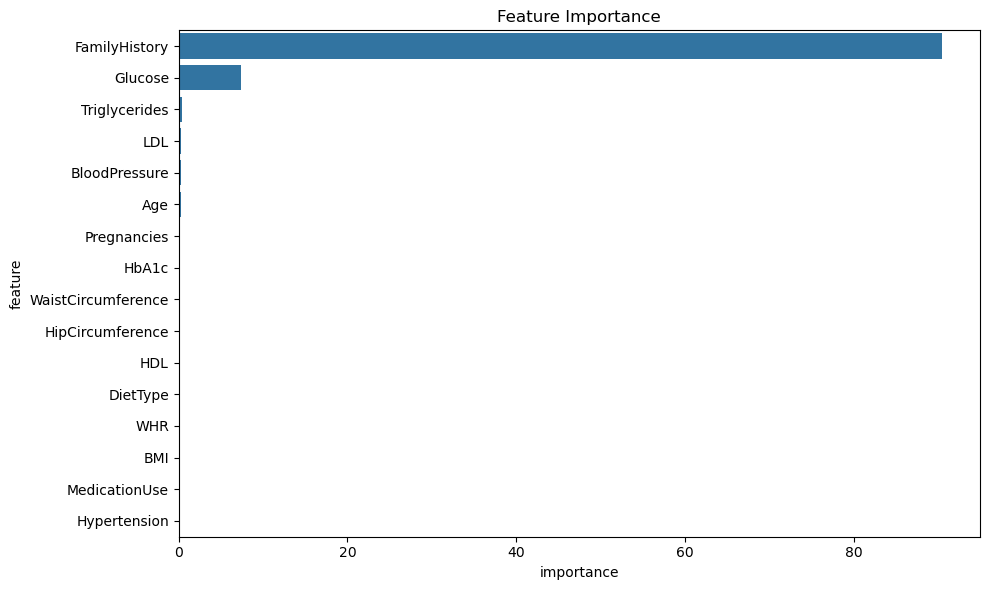

In [2]:
# Example usage
if __name__ == "__main__":
    # Initialize training manager
    training_manager = MLflowTrainingManager(
        experiment_name="CatBoost_Binary_Prediction",
        tracking_uri="http://localhost:5000",
        db_path="mlflow.db"
    )
    
    # Load your data
    df = pd.read_csv('diabetes_dataset.csv')
    
    # Train model
    model, metrics = training_manager.train_model(df, n_trials=100)